The source code is in the public domain and not licensed or under
copyright. The information and software may be used freely by the public.
As required by 17 U.S.C. 403, third parties producing copyrighted works
consisting predominantly of the material produced by U.S. government
agencies must provide notice with such work(s) identifying the U.S.
Government material incorporated and stating that such material is not
subject to copyright protection.

Derived works shall not identify themselves in a manner that implies an
endorsement by or an affiliation with the Naval Research Laboratory.

RECIPIENT BEARS ALL RISK RELATING TO QUALITY AND PERFORMANCE OF THE
SOFTWARE AND ANY RELATED MATERIALS, AND AGREES TO INDEMNIFY THE NAVAL
RESEARCH LABORATORY FOR ALL THIRD-PARTY CLAIMS RESULTING FROM THE ACTIONS
OF RECIPIENT IN THE USE OF THE SOFTWARE.

In [72]:
import numpy as np
from matplotlib import pyplot as plt
import ionization
import scipy.optimize
from scipy import constants as C
import input_tools

In [73]:
mks_length = 3.9e-6/(2*np.pi)
helper = input_tools.InputHelper(mks_length)
dnum = helper.dnum
terms = 40
Z = 0.53
w0 = 1.0
Uion = dnum('12.1 eV')
dens = dnum('5.4e18 cm-3')
ionizer = ionization.YI(mks_length,w0,Uion,Z,dens,terms,False)

In [74]:
intensity = dnum('4e13 W/cm2')
tau_L = dnum('100 fs')
time_window = dnum('400 fs')
Nt = 512
Nx = 4
Ny = 4
E0 = (2*intensity)**0.5
print('E0 =',ionizer.field_sim_to_au(E0),'a.u.')
dt = time_window/Nt
t0 = time_window/2
t = np.einsum('i,j,k',np.linspace(0,(Nt-1)*dt,Nt),np.ones(Nx),np.ones(Ny))
EField = E0*np.exp(-(t-t0)**2/tau_L**2)*np.cos(w0*t)
amp,phase,w0 = ionizer.ExtractEikonalForm(EField,dt)

E0 = 0.03376064561549883 a.u.


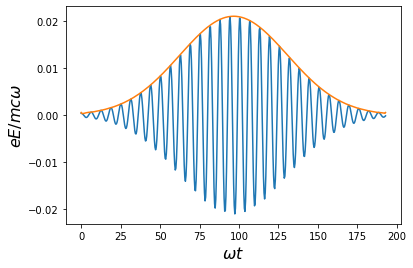

In [75]:
plt.plot(t[:,0,0],EField[:,0,0],t[:,0,0],amp[:,0,0])
plt.xlabel(r'$\omega t$',fontsize=16)
plt.ylabel(r'$eE/mc\omega$',fontsize=16)
plt.show()

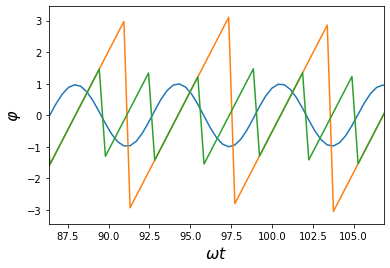

In [76]:
wrapped = phase[:,0,0]%(2*np.pi)
wrapped[np.where(wrapped>np.pi)] -= 2*np.pi
theta = (phase[:,0,0] - 0.5*np.pi)%np.pi - 0.5*np.pi
plt.plot(t[:,0,0],EField[:,0,0]/E0,t[:,0,0],wrapped,t[:,0,0],theta)
plt.xlim(t0-10/w0,t0+10/w0)
plt.xlabel(r'$\omega t$',fontsize=16)
plt.ylabel(r'$\varphi$',fontsize=16)
plt.show()

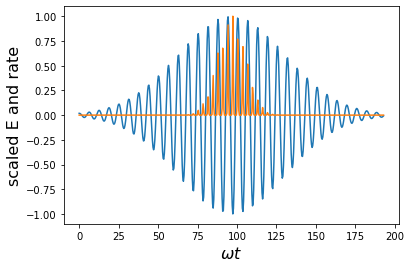

In [77]:
rate = ionizer.Rate(EField,False,dt)
plt.plot(t[:,0,0],EField[:,0,0]/E0,t[:,0,0],rate[:,0,0]/np.max(rate))
plt.xlabel(r'$\omega t$',fontsize=16)
plt.ylabel(r'scaled E and rate',fontsize=16)
plt.show()

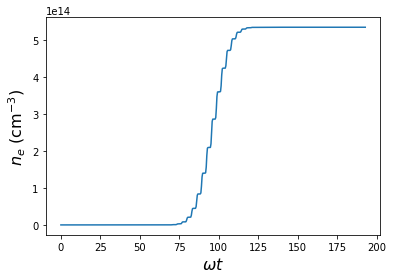

In [78]:
ng = np.ones(EField.shape[1:])
ne = ionizer.GetPlasmaDensity(rate,ng,dt)[::-1]
plt.plot(t[:,0,0],1e-6*helper.n1*ne[:,0,0])
plt.xlabel(r'$\omega t$',fontsize=16)
plt.ylabel(r'$n_e$ (cm$^{-3}$)',fontsize=16)
plt.show()

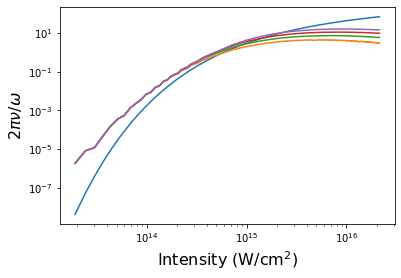

In [79]:
# Examine (non)convergence of PPT expansion
mks_length = 0.8e-6/(2*np.pi)
helper = input_tools.InputHelper(mks_length)
dnum = helper.dnum
w0 = 1.0
ionizer0 = ionization.PPT_Tunneling(mks_length,w0,Uion,Z,dens)
ionizer1 = ionization.PPT(mks_length,w0,Uion,Z,dens,10)
ionizer2 = ionization.PPT(mks_length,w0,Uion,Z,dens,20)
ionizer3 = ionization.PPT(mks_length,w0,Uion,Z,dens,40)
ionizer4 = ionization.PPT(mks_length,w0,Uion,Z,dens,80)
E_table = np.linspace(.003,0.1,256)

tunn_rate_table = ionizer0.Rate(E_table,True)
rate1_table = ionizer1.Rate(E_table,True)
rate2_table = ionizer2.Rate(E_table,True)
rate3_table = ionizer3.Rate(E_table,True)
rate4_table = ionizer4.Rate(E_table,True)

E_mks = E_table*(C.m_e*C.c*2*np.pi*C.c/0.8e-6)/C.e
intensity_Wcm2 = 1e-4 * E_mks**2 / (2*377)
plt.loglog(intensity_Wcm2,2*np.pi*tunn_rate_table)
plt.loglog(intensity_Wcm2,2*np.pi*rate1_table)
plt.loglog(intensity_Wcm2,2*np.pi*rate2_table)
plt.loglog(intensity_Wcm2,2*np.pi*rate3_table)
plt.loglog(intensity_Wcm2,2*np.pi*rate4_table)
plt.xlabel(r'Intensity (W/cm$^2$)',fontsize=16)
plt.ylabel(r'$2\pi\nu/\omega$',fontsize=16)
plt.show()

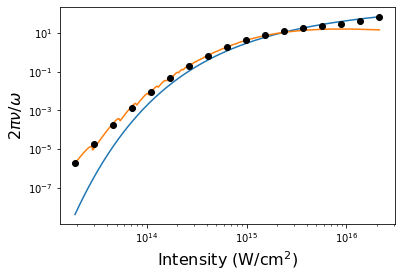

In [80]:
# Comparison of tunneling and log-fits to full formula
ionizer0 = ionization.PPT_Tunneling(mks_length,w0,Uion,Z,dens)
ionizer1 = ionization.PPT(mks_length,w0,Uion,Z,dens,80)
ionizer2 = ionization.StitchedPPT(mks_length,w0,Uion,Z,dens,80)
E_table = np.logspace(np.log10(.003),np.log10(0.1),257)

tunn_rate_table = ionizer0.Rate(E_table,True)
rate_table = ionizer1.Rate(E_table,True)
fit_table = ionizer2.FittedRate(E_table,True)

E_mks = E_table*(C.m_e*C.c*2*np.pi*C.c/0.8e-6)/C.e
intensity_Wcm2 = 1e-4 * E_mks**2 / (2*377)

plt.loglog(intensity_Wcm2,2*np.pi*tunn_rate_table)
plt.loglog(intensity_Wcm2,2*np.pi*rate_table)
plt.loglog(intensity_Wcm2[::16],2*np.pi*fit_table[::16],'ko')
plt.xlabel(r'Intensity (W/cm$^2$)',fontsize=16)
plt.ylabel(r'$2\pi\nu/\omega$',fontsize=16)
plt.show()

Text(0, 0.5, '$eE/mc\\omega$')

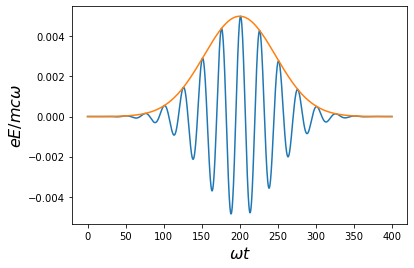

In [81]:
# Examine discretization errors in plasma density
# First create a new carrier resolved and envelope field
w0 = 0.25
time_window = 400.0
Nt = 4096
Nx = 4
Ny = 4
E0 = .005
dt = time_window/Nt
t0 = time_window/2
tau_L = time_window/6
t = np.einsum('i,j,k',np.linspace(0,(Nt-1)*dt,Nt),np.ones(Nx),np.ones(Ny))
EField = E0*np.exp(-(t-t0)**2/tau_L**2)*np.cos(w0*t)
EField += 0.0*E0*np.exp(-(t-t0)**2/tau_L**2)*np.cos(2*w0*t+np.pi/2)
amp,phase,w0d = ionizer.ExtractEikonalForm(EField,dt)

plt.plot(t[:,0,0],EField[:,0,0],t[:,0,0],amp[:,0,0])
plt.xlabel(r'$\omega t$',fontsize=16)
plt.ylabel(r'$eE/mc\omega$',fontsize=16)

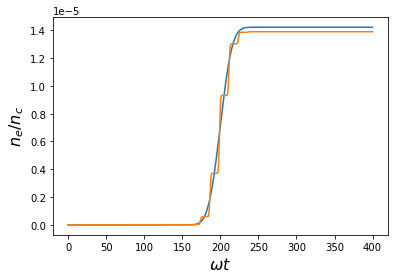

Relative Error = -0.02316330063163763


In [82]:
ionizer = ionization.PPT_Tunneling(mks_length,w0,Uion,Z,dens,80)
paraxial_rate = ionizer.Rate(amp,True)
uppe_rate = ionizer.Rate(EField,False)
ng = np.ones(EField.shape[1:])
paraxial_ne = ionizer.GetPlasmaDensity(paraxial_rate,ng,dt)[::-1]
uppe_ne = ionizer.GetPlasmaDensity(uppe_rate,ng,dt)[::-1]
plt.plot(t[:,0,0],paraxial_ne[:,0,0],t[:,0,0],uppe_ne[:,0,0])
plt.xlabel(r'$\omega t$',fontsize=16)
plt.ylabel(r'$n_e/n_c$',fontsize=16)
plt.show()
print('Relative Error =',1-paraxial_ne[-1,0,0]/uppe_ne[-1,0,0])